## Advanced Algorithmic Trading DT - V2

### Updates from Last Version (ToDo)
- Fix Train/Test to Time Series Train Test Split
- Train/Validate/Test

#### Import Packages

In [13]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

import datetime
import gc
from sklearn.ensemble import (BaggingRegressor, RandomForestRegressor, AdaBoostRegressor)
from sklearn.metrics import mean_squared_error
from technical_indicators import * # import all function
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
#import parfit as pf
from sklearn.metrics import r2_score
from sklearn.preprocessing import scale

from sklearn.model_selection import ParameterGrid
from sklearn.tree import DecisionTreeRegressor
from sklearn import linear_model

#### Set Parameters

In [14]:
# Set the random seed, number of estimators and the "step factor" used to plot the graph of MSE for each method
random_state = 42  # Seed
n_jobs = -1 # -1 --> all Processors # Parallelisation factor for bagging, random forests (controls the number of processor cores used)
n_estimators = 200 # total number of estimators ot use in the MSE graph
step_factor = 10 # controls cranularity of calculation by stepping through the number of estimators
axis_step = int(n_estimators / step_factor) # 1000/10 = 100 separate calculations will be performed for each of the 3 ensebmle methods


#### Read in Data via GitHub URL

In [15]:
url = "https://raw.githubusercontent.com/meenmo/Stat479_Project/master/Data/IBM.csv"
df_ORIGINAL = pd.read_csv(url)


***
## Clean Data & Create Technical Indicator Variables

- Create Deep copy of dataframe
- Use Adjusted Close Data
- Drop Close 
- Rename "Adj. Close" as "Close"
- Create Lagged Features
- Drop NaN
- Create Technical Indicator Variables
- Drop NaN
- Re-set index as Date

In [16]:
df_features = df_ORIGINAL.copy(deep=True) # Create Deep
df_features.drop(['Close'], axis = 1, inplace = True) # drop close column
df_features.columns = ['Date', 'High', 'Low', 'Open', 'Volume', 'Close'] # Close is actually Adj. Close

df_features['Date'] = pd.to_datetime(df_features['Date'])
#df_features.head() # sanity check


"""
Creates Lagged Returns 
- given OHLCV dataframe
- numer of lagged days
"""
def create_lag_features(df, lag_days):
    df_ret = df.copy()
    
    # iterate through the lag days to generate lag values up to lag_days + 1
    for i in range(1,lag_days + 2):
        df_lag = df_ret[['Date', 'Close']].copy()
        # generate dataframe to shift index by i day.
        df_lag['Date'] = df_lag['Date'].shift(-i)
        df_lag.columns = ['Date', 'value_lag' + str(i)]
        # combine the valuelag
        df_ret = pd.merge(df_ret, df_lag, how = 'left', left_on = ['Date'], right_on = ['Date'])
    
    #frees memory
    del df_lag
    
    # calculate today's percentage lag
    df_ret['Today'] = (df_ret['Close'] - df_ret['value_lag1'])/(df_ret['value_lag1']) * 100.0 
    
    # calculate percentage lag
    for i in range(1, lag_days + 1):
        df_ret['lag' + str(i)] = (df_ret['value_lag'+ str(i)] - df_ret['value_lag'+ str(i+1)])/(df_ret['value_lag'+str(i+1)]) * 100.0
    
    # drop unneeded columns which are value_lags
    for i in range(1, lag_days + 2):
        df_ret.drop(['value_lag' + str(i)], axis = 1, inplace = True)
                                                                                                                                                                                                                                                                                                                                     
    return df_ret


### Run Function
df_features = create_lag_features(df_features, 5) # 5 lag features
#df_features.head(7)

# drop earlier data with missing lag features
df_features.dropna(inplace=True)
# reset index
df_features.reset_index(drop = True, inplace = True)


#### GENERATE TECHNICAL INDICATORS FEATURES
df_features = standard_deviation(df_features, 14)

df_features = relative_strength_index(df_features, 14) # periods
df_features = average_directional_movement_index(df_features, 14, 13) # n, n_ADX
df_features = moving_average(df_features, 21) # periods
df_features = exponential_moving_average(df_features, 21) # periods
df_features = momentum(df_features, 14) # 

df_features = average_true_range(df_features, 14)
df_features = bollinger_bands(df_features, 21)
df_features = ppsr(df_features)
df_features = stochastic_oscillator_k(df_features)
df_features = stochastic_oscillator_d(df_features, 14)
df_features = trix(df_features, 14)
df_features = macd(df_features, 26, 12)
df_features = mass_index(df_features)
df_features = vortex_indicator(df_features, 14)

df_features = kst_oscillator(df_features, 10, 10, 10, 15, 10, 15, 20, 30)
df_features = true_strength_index(df_features, 25, 13)

#df_features = accumulation_distribution(df_features, 14) # Causes Problems, apparently
df_features = chaikin_oscillator(df_features)
df_features = money_flow_index(df_features, 14)
df_features = on_balance_volume(df_features, 14)
df_features = force_index(df_features, 14)
df_features = ease_of_movement(df_features, 14)
df_features = commodity_channel_index(df_features, 14)
df_features = keltner_channel(df_features, 14)
df_features = ultimate_oscillator(df_features)
df_features = donchian_channel(df_features, 14)
    
# drop earlier data with missing lag features
df_features.dropna(inplace=True)
df_features = df_features.reset_index(drop = True)


# Re-set "Date" as the index
df_features = df_features.set_index('Date')

### Sanity Check
df_features.head(10)


,High,Low,Open,Volume,Close,Today,lag1,lag2,lag3,lag4,...,MFI_14,OBV_14,Force_14,EoM_14,CCI_14,KelChM_14,KelChU_14,KelChD_14,Ultimate_Osc,Donchian_14
Date,,,,,,,,,,,,,,,,,,,,,
2002-03-14,107.949997,106.589996,107.019997,5335500,74.391068,-0.541176,-1.216580,3.097695,0.142742,1.330632,...,0.714286,1.962464e+06,-2.921157e+07,2.286739e-07,0.959960,93.032764,95.832764,90.232765,0.034641,13.389999
2002-03-15,107.449997,105.589996,106.550003,10864100,74.523666,0.178246,-0.541176,-1.216580,3.097695,0.142742,...,0.642857,3.445814e+06,5.695471e+06,2.086708e-07,0.713277,93.570735,96.351449,90.790020,0.031385,13.389999
2002-03-18,108.639999,106.230003,107.099999,5301200,74.216637,-0.411990,0.178246,-0.541176,-1.216580,3.097695,...,0.714286,3.898193e+06,-4.066156e+07,2.500726e-07,0.779588,94.192408,96.916693,91.468123,0.058735,13.389999
2002-03-19,108.050003,106.489998,106.849999,4614800,75.012154,1.071885,-0.411990,0.178246,-0.541176,-1.216580,...,0.714286,3.372200e+06,-4.964177e+07,2.263920e-07,0.762796,94.770295,97.348152,92.192438,0.057835,13.389999
2002-03-20,106.900001,105.489998,106.900001,4844100,73.623466,-1.851283,1.071885,-0.411990,0.178246,-0.541176,...,0.642857,2.459121e+06,-1.593928e+07,2.007584e-07,0.060704,95.249347,97.800775,92.697918,0.026201,13.389999
2002-03-21,106.779999,104.699997,105.699997,5113100,74.516685,1.213226,-1.851283,1.071885,-0.411990,0.178246,...,0.571429,2.074850e+06,-1.411611e+07,1.220918e-07,-0.248791,95.547059,97.918488,93.175630,-0.008129,13.389999
2002-03-22,106.699997,105.070000,106.500000,5507900,73.693192,-1.105114,1.213226,-1.851283,1.071885,-0.411990,...,0.500000,9.123071e+05,1.101343e+06,3.426329e-08,-0.533297,95.592311,97.837311,93.347311,-0.021320,13.389999
2002-03-25,106.660004,103.500000,105.800003,6277900,72.269615,-1.931761,-1.105114,1.213226,-1.851283,1.071885,...,0.428571,1.004036e+06,1.890940e+06,-5.730833e-09,-1.582313,95.545348,97.848920,93.241776,-0.045311,13.389999
2002-03-26,105.699997,102.300003,103.570000,8144000,71.809052,-0.637285,-1.931761,-1.105114,1.213226,-1.851283,...,0.357143,-1.267786e+05,-1.083363e+06,-5.076478e-08,-1.978289,95.397427,97.776713,93.018141,-0.061006,11.739998


## Create X & y

Drop all data used to create technical indicators (this is done in the book)

NOTE: some technical indicators use Present  data, but ofr simplicity, just ignore this

In [23]:
### X
list_of_columns_to_exclude = ["High", "Low", "Open", "Volume","Close", "Today"]
X = df_features.copy(deep=True)

X.drop(list_of_columns_to_exclude, axis = 1, inplace = True) # drop close column

### y
y = df_features["Today"]

# Sanity check
# X.head()
# y.head()

# Scale data: 0-1
#X = scale(X)
#y = scale(np.array(y)) # need to convert to numpy array first
# Convert scaled X,Y back to pandas


In [ ]:
"""
Random Forest Function
"""
def Call_Random_Forest();
    for i in range(0, axis_step):
        print("Random Forest Estimator: %d of %d..." % (
            step_factor * (i + 1), n_estimators)
              )
        rf = RandomForestRegressor(
            n_estimators=150, # as determined in v1
            n_jobs=5, # subject to change
            random_state=123 # arbitrary
        )
        rf.fit(X_train, y_train)
        prediction = rf.predict(X_test)

        mse = mean_squared_error(y_test, prediction)
        r2  = r2_score(y_test, prediction)



#### Split: Train & Validatte / Test

- Train & Validate: < '2018-01-01'
- Test: >= '2018-01-01'

In [35]:
# # all training data
X_train_all = X.loc[(X.index < '2018-01-01')]
y_train_all = y[X_train_all.index]

# # creates all test data which is all after January 2018
X_test = X.loc[(X.index >= '2018-01-01'),:]
y_test = y[X_test.index]



### Time Series Train Test Split ---- 


In [88]:

### Prepare Random Forest
##############################################################################
# Initialize Random Forest Instance
rf = RandomForestRegressor(n_estimators=150, n_jobs=5, random_state=123)

rf_mse = [] # MSE
rf_r2 = [] # R2


### Time Series Split
##############################################################################
splits = TimeSeriesSplit(n_splits=30) # 3 splits

splitCount = 0 # dummy count var to track current split num in print statements
for train_index, test_index in splits.split(X_train_all):
    splitCount += 1 
    
    # Train Split
    X_train = X_train_all.iloc[0:len(train_index) - 1,:].copy(deep=True)
    y_train = y[X_train.index]
        
    # Validate Split
    X_val = X_train_all.iloc[len(train_index) - 1:,:].copy(deep=True)
    y_val = y[X_val.index]
    
    # Print Statements
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    print("Split: ", splitCount)
    print('Observations: ', (X_train.shape[0] + X_test.shape[0]))
    #print('Cutoff date, or first date in validation data: ', X_val.iloc[0,0])
    print('Training Observations: ', (X_train.shape[0]))
    print('Testing Observations: ', (X_test.shape[0]))
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    
    ### Run Random Forest
    rf.fit(X_train, y_train)
    prediction = rf.predict(X_val)
    
    mse = mean_squared_error(y_val, prediction)
    r2  = r2_score(y_val, prediction)
    
    rf_mse.append(mse)
    rf_r2.append(r2)

# print("rf_mse: ", rf_mse)
# print("rf_r2: ", rf_r2)



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Split:  1
Observations:  349
Training Observations:  138
Testing Observations:  211
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Split:  2
Observations:  477
Training Observations:  266
Testing Observations:  211
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Split:  3
Observations:  605
Training Observations:  394
Testing Observations:  211
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Split:  4
Observations:  733
Training Observations:  522
Testing Observations:  211
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Split:  5
Observations:  

### Plot - MSE

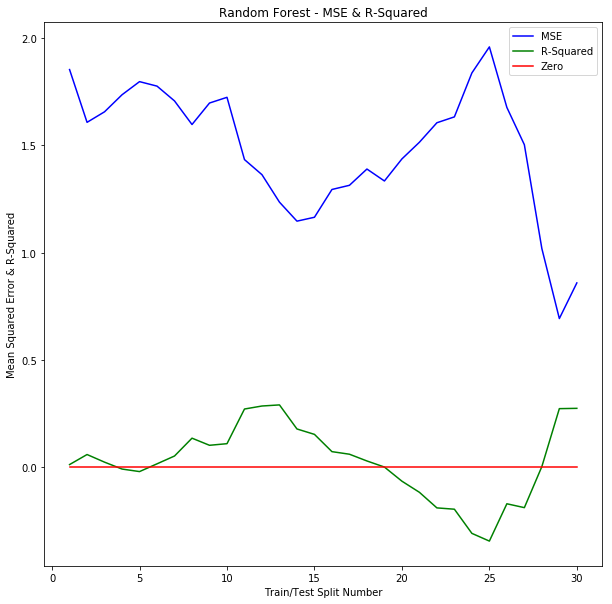

In [90]:
# Plot the chart of MSE versus number of estimators
plt.figure(figsize=(10, 10))
plt.title('Random Forest - MSE & R-Squared')

### MSE
plt.plot(list(range(1,splitCount+1)), rf_mse, 'b-', color="blue", label='MSE')
plt.plot(list(range(1,splitCount+1)), rf_r2, 'b-', color="green", label='R-Squared')
plt.plot(list(range(1,splitCount+1)), np.array([0] * splitCount), 'b-', color="red", label='Zero')


plt.legend(loc='upper right')
plt.xlabel('Train/Test Split Number')
plt.ylabel('Mean Squared Error & R-Squared')
plt.show()

### Plot - R2

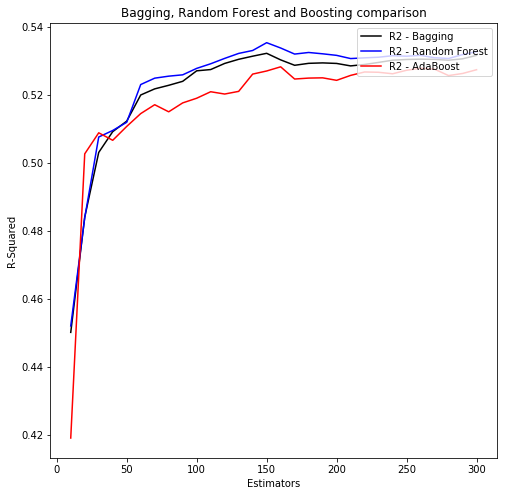

In [63]:
# Plot the chart of MSE versus number of estimators
plt.figure(figsize=(8, 8))
plt.title('Bagging, Random Forest and Boosting comparison')

### R2
plt.plot(estimators, bagging_r2, 'b-', color="black", label='R2 - Bagging')
plt.plot(estimators, rf_r2, 'b-', color="blue", label='R2 - Random Forest')
plt.plot(estimators, boosting_r2, 'b-', color="red", label='R2 - AdaBoost')

plt.legend(loc='upper right')
plt.xlabel('Estimators')
plt.ylabel('R-Squared')
plt.show()

#### NOTE: For Random Forests, 150 Estimators seems optimal. 

- We can interpret the plot above similarly to a scree plot. We look for the elbow in the plot which signifies where additional estimators provides decreassing benefit
- The optimal number of estimators for random forests & bagging is actually arround 400 but this seems a little too large, since we're not running supercomputers. So for computaional purposes 150 surves us better.
- Using Adjusted Close prices decreases our MSE & increases our R2
- Using more features than just Lagged returns decreases our MSE & increases our R2


##### Random Forest
- Optimal: __150 Estimators__

##### Bagging
- Optimal: __150 Estimators__

##### Boosting
- Optimal: __150 Estimators__
- Note the when only Lag features are used, the optimal number of estimators is around 50 and is in a U shape, but when more features are included out MSE become monotone decreasing 

